
# ABC Diagnostics: Coverage, Residuals, and PPC (Early vs Late)

This notebook loads a **pyABC** SQLite database, draws **posterior parameter samples** from the **last population**, re-simulates your ABM to compute **posterior predictive checks (PPC)**, and reports:

- **Coverage** of the observed time series within 5–95% posterior predictive bands (per statistic; overall; early vs late windows).
- **Residuals** (observed − posterior median) per statistic over time.
- **Side‑by‑side PPC** panels for **early** and **late** windows.
- A **discrepancy vs time** diagnostic (Euclidean distance between observed and posterior median across stats).
- **Heuristic recommendations** for parameter/model changes based on late‑phase residual patterns.

> **Requirements**: Run this in your project environment where `pyabc`, your ABM modules (`abm.clusters_model`, `abcp.compute_summary`, `abcp.abc_model_wrapper`), `numpy`, `pandas`, and `matplotlib` are installed.

> **References (API we use):**
> - `pyabc.storage.History`: querying posteriors, populations, distances; e.g., `History.get_distribution`, `History.get_all_populations` (pyABC docs).  
>   See: https://pyabc.readthedocs.io/en/latest/api/pyabc.storage.html
    


In [1]:

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure inline plots
%matplotlib inline

# Optional: nicer style
plt.style.use('seaborn-v0_8-whitegrid')

from pyabc import History  # pyABC data access

# Project-specific imports (available in your environment)
from abm.clusters_model import ClustersModel
from abcp.compute_summary import simulate_timeseries
from abcp.abc_model_wrapper import particle_to_params



## 1) Inputs
Set the paths and options below. If your DB path is relative, **do not** prepend `sqlite:///`; the cell will construct the proper SQLAlchemy URI.


In [2]:

# --- User inputs ---
# Path to your pyABC SQLite DB (file produced by your run_abc_* scripts)
db_path = "results/abc_maxabs_nogr_1000_10.db"  # <-- change this

# Observed summary CSV used in calibration (must include 'timestep' and selected stats)
observed_csv = "observed/INV_ABM_ready_summary.csv"  # <-- change this

# Which statistics to analyze
enable_gr = False  # set True if your observed CSV includes g(r) columns
stats = ["S0", "S1", "S2", "NND_med"] if not enable_gr else ["S0", "S1", "S2", "NND_med", "g_r40", "g_r80"]

# Time windows
# Either give an explicit cutoff timestep (e.g., 50) or set to None and
# a percentile-based split will be used (late = upper 40% by default)
explicit_cut = None
late_fraction = 0.4  # used if explicit_cut is None

# Number of posterior samples to draw for PPC
n_post_samples = 400

# Model/simulation options
motion = "persistent"   # same as calibration
speed  = "lognorm"       # same as calibration
seed_base = 12345        # base RNG seed for PPC simulations

# Total steps and the exact timesteps to sample must match your calibration
# (the observed CSV defines the set of timesteps)
total_steps = 300



## 2) Load observed data and pyABC history
This uses `pyabc.storage.History` to connect to the database and `History.get_distribution()` to retrieve the **last population's weighted particles** (parameters and weights).  
See the pyABC API docs for `History` and these query methods.


In [3]:

# Build SQLAlchemy URI for pyABC
if db_path.startswith("sqlite://"):
    db_uri = db_path
else:
    db_uri = f"sqlite:///{db_path}"

# Load history
h = History(db_uri)
run_id = h.id
print(f"Loaded DB: {db_uri} (run id={run_id})")

# Observed CSV
obs_df = pd.read_csv(observed_csv).sort_values("timestep").reset_index(drop=True)
for s in ["timestep"] + stats:
    if s not in obs_df.columns:
        raise ValueError(f"Observed CSV missing column: {s}")

# Timesteps and observed matrix
timesteps = obs_df["timestep"].astype(int).to_list()
obs_mat = obs_df[stats].to_numpy(float)  # shape (T, K)
T, K = obs_mat.shape

# Early/late split
if explicit_cut is not None:
    cut = explicit_cut
else:
    # late starts at the (1 - late_fraction) quantile of timesteps
    q = 1.0 - late_fraction
    cut = int(np.quantile(timesteps, q))

early_mask = (obs_df["timestep"] <= cut).to_numpy()
late_mask  = ~early_mask
print(f"Time split: early ≤ {cut}, late > {cut}")


Loaded DB: sqlite:///results/abc_maxabs_nogr.db (run id=1)
Time split: early ≤ 53, late > 53



## 3) Draw posterior parameter samples
We query the **last population** via `History.get_distribution(m)` to obtain a DataFrame of parameter values and a corresponding weight vector. We then **resample** `n_post_samples` parameter sets according to those weights.

> API reference: `History.get_distribution` (pyABC docs). 


In [4]:

# Get last population's weighted parameters for model m=0
params_df, weights = h.get_distribution(m=0)  # last population by default
weights = np.asarray(weights, dtype=float)
weights = weights / weights.sum()
print(f"Retrieved {len(params_df)} weighted particles from the last population.")

# Weighted resampling of parameter rows
rng = np.random.default_rng(seed_base)
idx = rng.choice(len(params_df), size=n_post_samples, replace=True, p=weights)
post_samples = params_df.iloc[idx].reset_index(drop=True)
post_samples.head()


Retrieved 500 weighted particles from the last population.


name,adhesion,fragment_rate,heading_sigma,init_n_clusters,merge_prob,prolif_rate,speed_meanlog,speed_sdlog
0,0.519731,0.007722,0.432081,526.997626,0.817033,0.017262,1.306078,0.310251
1,0.461370,0.004090,0.238239,1012.881569,0.485397,0.005811,1.853819,0.228878
2,0.340096,0.003768,0.711882,477.555408,0.813798,0.016919,1.073183,0.910490
3,0.748224,0.004735,0.257397,778.021703,0.721317,0.011887,0.374476,1.370405
4,0.994017,0.005659,0.748562,1129.550323,0.474845,0.003937,1.477533,0.606732



## 4) Posterior predictive simulations
For each sampled parameter vector, we map to the model’s internal parameterization using your project’s `particle_to_params` helper, build a `ClustersModel` via a factory, and call `simulate_timeseries` at the observed timesteps. Each draw uses a distinct RNG seed for stochasticity.


In [5]:

# Prepare a model factory with variable seed per draw

def make_model(seed: int):
    def factory(params_dict):
        return ClustersModel(params=params_dict, seed=seed)
    return factory

# Run PPC simulations
sim_cube = np.zeros((n_post_samples, T, K), dtype=float)

for i in range(n_post_samples):
    particle = post_samples.iloc[i].to_dict()
    params = particle_to_params(particle, motion=motion, speed_dist=speed)
    model_factory = make_model(seed_base + i)
    sim_mat = simulate_timeseries(
        model_factory,
        params=params,
        total_steps=total_steps,
        sample_steps=tuple(timesteps),
    )
    # Align columns to `stats`
    full_order = ["S0", "S1", "S2", "NND_med", "g_r40", "g_r80"]
    col_idx = [full_order.index(s) for s in stats]
    sim_sel = sim_mat[:, col_idx]
    sim_cube[i] = sim_sel

print(f"Completed PPC: sim_cube shape = {sim_cube.shape} (samples x T x K)")


Completed PPC: sim_cube shape = (400, 53, 4) (samples x T x K)



## 5) Summaries: quantiles, coverage, residuals, discrepancy
- **Quantiles**: 5%, 50%, 95% per time point & statistic.
- **Coverage**: fraction of time points where observed lies between 5% and 95%. Also reported separately for early and late windows.
- **Residuals**: observed − posterior median per time point & statistic.
- **Discrepancy vs time**: Euclidean distance between observed vector and posterior-median vector across stats at each time.


In [6]:
q_lo = np.percentile(sim_cube, 5, axis=0)
q_md = np.percentile(sim_cube, 50, axis=0)
q_hi = np.percentile(sim_cube, 95, axis=0)

# Coverage
inside = (obs_mat >= q_lo) & (obs_mat <= q_hi)
cov_overall = inside.mean(axis=0)  # per stat
cov_early   = inside[early_mask].mean(axis=0)
cov_late    = inside[late_mask].mean(axis=0)

cov_df = pd.DataFrame({
    'stat': stats,
    'coverage_overall': cov_overall,
    'coverage_early': cov_early,
    'coverage_late': cov_late,
})

# Residuals (obs - posterior median)
residuals = obs_mat - q_md  # T x K
residuals_df = pd.DataFrame(residuals, columns=stats)
residuals_df.insert(0, 'timestep', timesteps)

# Euclidean discrepancy across stats per timepoint
sq = (obs_mat - q_md) ** 2
disc = np.sqrt(sq.sum(axis=1))

print("Coverage (fraction of timepoints within 5-95 band) per stat:")
display(cov_df)

Coverage (fraction of timepoints within 5-95 band) per stat:


,stat,coverage_overall,coverage_early,coverage_late
0,S0,1.000000,1.0000,1.0
1,S1,0.886792,0.8125,1.0
2,S2,0.849057,0.7500,1.0
3,NND_med,0.075472,0.1250,0.0



## 6) PPC panels (early vs late)
Each panel shows the **posterior median** (blue), **5–95% band** (blue fill), and the **observed** trajectory (black) over the respective window.


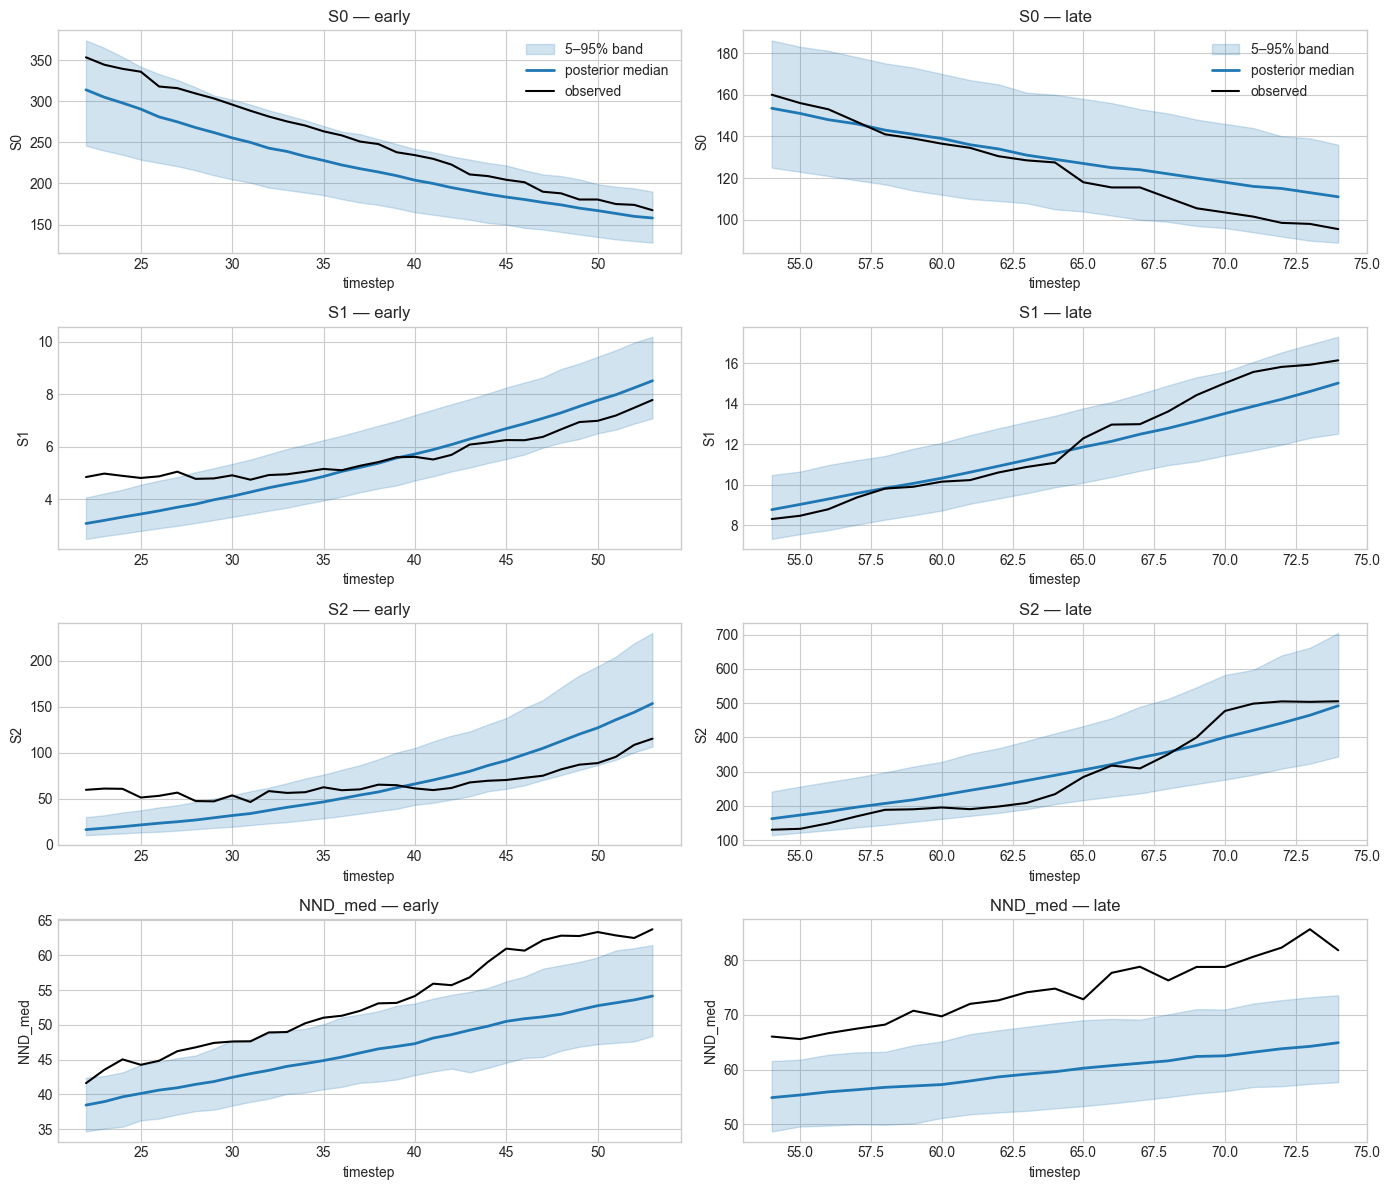

In [7]:

import math

def plot_ppc(ax, tmask, title_suffix):
    t = np.array(timesteps)[tmask]
    for k, s in enumerate(stats):
        ax[k].fill_between(t, q_lo[tmask, k], q_hi[tmask, k], color='C0', alpha=0.2, label='5–95% band' if k==0 else None)
        ax[k].plot(t, q_md[tmask, k], color='C0', lw=2, label='posterior median' if k==0 else None)
        ax[k].plot(t, obs_mat[tmask, k], color='k', lw=1.5, label='observed' if k==0 else None)
        ax[k].set_title(f"{s} — {title_suffix}")
        ax[k].set_xlabel("timestep")
        ax[k].set_ylabel(s)
    handles, labels = ax[0].get_legend_handles_labels()
    if labels:
        ax[0].legend(loc='best')

fig, axes = plt.subplots(len(stats), 2, figsize=(14, 3*len(stats)), sharex=False)
if len(stats) == 1:
    axes = np.array([axes])

plot_ppc(axes[:,0], early_mask, "early")
plot_ppc(axes[:,1], late_mask,  "late")
plt.tight_layout()
plt.savefig('ppc_init.png', dpi=300)
plt.show()



## 7) Residuals per statistic (obs − posterior median)
Positive residuals mean the **observed** is **above** the model’s predictive median; negative means the model’s median is above the observed.


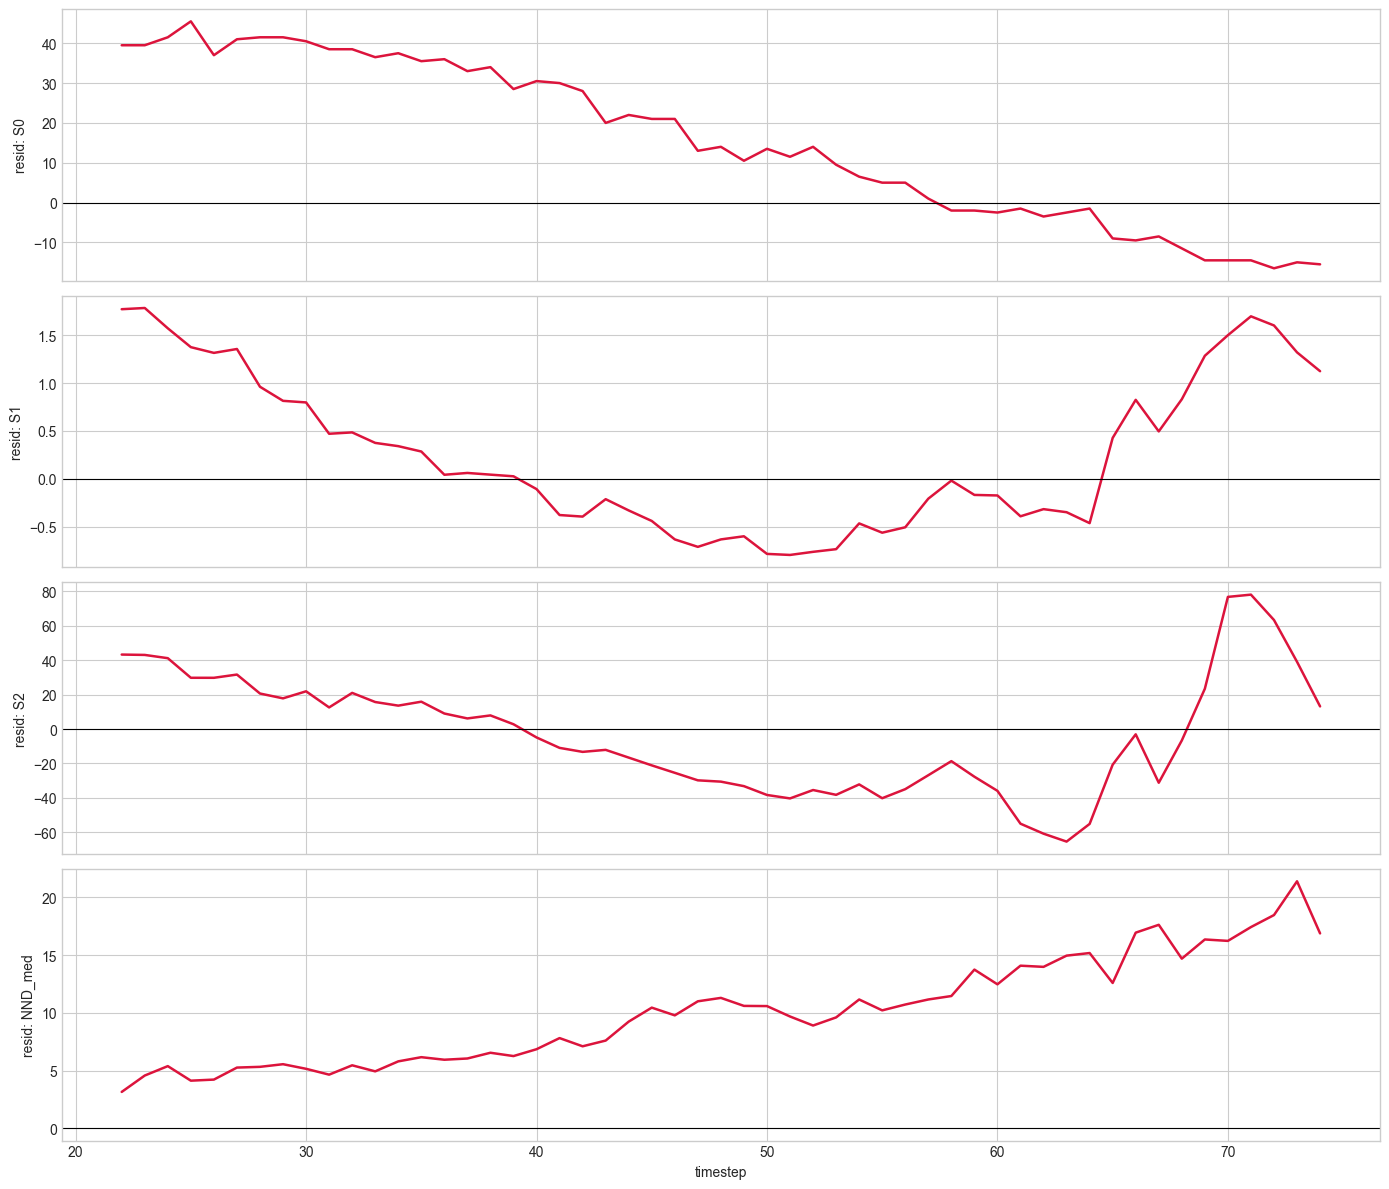

In [8]:

fig, ax = plt.subplots(len(stats), 1, figsize=(14, 3*len(stats)), sharex=True)
if len(stats) == 1:
    ax = [ax]

for k, s in enumerate(stats):
    ax[k].plot(timesteps, residuals[:, k], color='crimson', lw=1.8)
    ax[k].axhline(0, color='k', lw=0.8)
    ax[k].set_ylabel(f"resid: {s}")
ax[-1].set_xlabel("timestep")
plt.tight_layout()
plt.show()



## 8) Euclidean discrepancy vs time
This is the Euclidean norm of residuals across the selected stats at each time point.


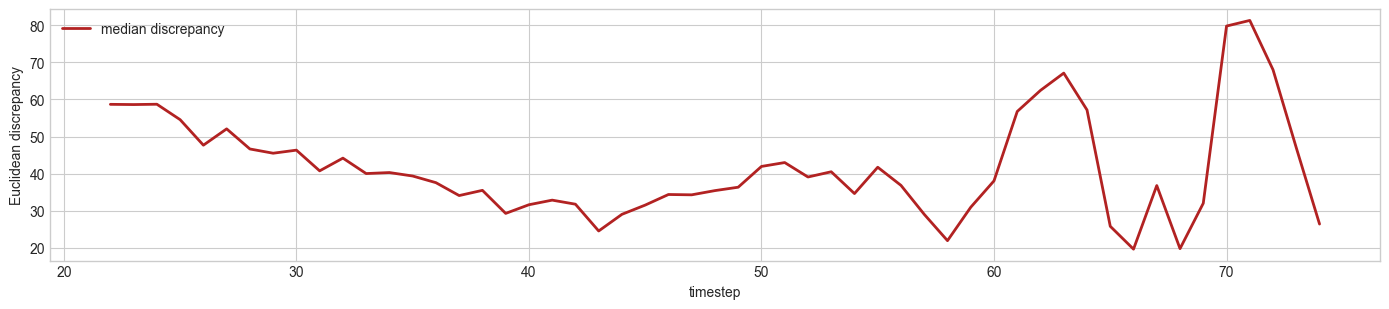

In [9]:

fig, ax = plt.subplots(1,1, figsize=(14, 3.2))
ax.plot(timesteps, disc, color='firebrick', lw=2, label='median discrepancy')
# 5–95% band across samples for the Euclidean discrepancy (optional, compute approx) 
# We'll approximate by using posterior quantiles of each stat and summing their squares is not exact for quantiles,
# so we keep just the median curve here for robustness.
ax.set_xlabel('timestep')
ax.set_ylabel('Euclidean discrepancy')
ax.legend(loc='best')
plt.tight_layout()
plt.show()



## 9) Heuristic recommendations
We generate suggestions automatically based on **late‑phase** residual patterns (median over late window):
- If `S0` residual is **negative** (model median > observed): model depletes S0 **too slowly** → consider faster transitions/merging out of S0.
- If `S1`/`S2` residuals are **positive** and large: model **under‑produces** these at late times → consider stronger adhesion/merging, density‑dependent acceleration, or heavier‑tailed speed/persistence.
- If `NND_med` residual is **positive**: observed spacing > model → reduce aggregation / increase dispersal or heterogeneity.
- If late coverage ≪ early coverage: consider **time‑weighted** distances or **piecewise** fitting.


In [10]:

# Summaries for heuristic rules
late_resid_mean = residuals[late_mask].mean(axis=0)  # per stat
recos = []

# Helper to fetch coverage
cov_map = {row['stat']: row for _, row in cov_df.iterrows()}

for k, s in enumerate(stats):
    cov_e = float(cov_map[s]['coverage_early']) if s in cov_map else np.nan
    cov_l = float(cov_map[s]['coverage_late'])  if s in cov_map else np.nan
    recos.append({
        'stat': s,
        'late_residual_mean': float(late_resid_mean[k]),
        'coverage_early': cov_e,
        'coverage_late':  cov_l,
    })

reco_df = pd.DataFrame(recos)
print("Late-window residual means and coverages:")
display(reco_df)

# Textual recommendations
messages = []

# S0 too slow to decline
if 'S0' in stats:
    k = stats.index('S0')
    if late_resid_mean[k] < -0.05 * max(1.0, np.nanmax(obs_mat[:,k])):  # scale-agnostic heuristic
        messages.append("S0 declines too slowly relative to data: increase depletion/transition rate from S0; allow faster merging; consider time‑dependent or density‑dependent rate.")

# S1/S2 under-produced late
for s in ['S1','S2']:
    if s in stats:
        k = stats.index(s)
        if late_resid_mean[k] > 0.05 * max(1.0, np.nanmax(obs_mat[:,k])):
            messages.append(f"{s} under‑produced late: add/strengthen adhesion or merging kinetics; introduce density‑dependent acceleration; broaden speed/persistence distribution (heavier tail).")

# NND_med too small (model packs too much)
if 'NND_med' in stats:
    k = stats.index('NND_med')
    if late_resid_mean[k] > 0.02 * max(1.0, np.nanmax(obs_mat[:,k])):
        messages.append("NND_med lower than observed (model more compact): reduce aggregation strength; increase dispersal or heterogeneity in motion (e.g., wider log-normal speed/persistence).")

# Coverage deterioration
if (cov_df['coverage_late'].mean() + 1e-12) < (cov_df['coverage_early'].mean() - 0.15):
    messages.append("Coverage drops substantially in late phase: use time‑weighted or windowed distances (e.g., higher weight after the split); try a two‑stage fit.")

print("Suggested actions (heuristic):")
if messages:
    for i, m in enumerate(messages, 1):
        print(f"{i}. {m}")
else:
    print("No strong systematic late‑phase bias detected by the heuristics.")


Late-window residual means and coverages:


,stat,late_residual_mean,coverage_early,coverage_late
0,S0,-6.047619,1.0000,1.0
1,S1,0.357142,0.8125,1.0
2,S2,-10.493576,0.7500,1.0
3,NND_med,14.656202,0.1250,0.0


Suggested actions (heuristic):
1. NND_med lower than observed (model more compact): reduce aggregation strength; increase dispersal or heterogeneity in motion (e.g., wider log-normal speed/persistence).



## 10) Save key artifacts
This cell saves coverage and residuals tables to `results/` for reporting.


In [11]:

Path('results').mkdir(exist_ok=True, parents=True)

cov_out = Path('results/diagnostics_coverage.csv')
resid_out = Path('results/diagnostics_residuals.csv')

cov_df.to_csv(cov_out, index=False)
residuals_df.to_csv(resid_out, index=False)

print(f"Saved: {cov_out} Saved: {resid_out}")


Saved: results/diagnostics_coverage.csv Saved: results/diagnostics_residuals.csv
